# Transfer Learning Using Pretrained ConvNets

In this tutorial we will discuss how to classify cats vs dogs images by using transfer learning from a pre-trained network. This will allows us to get higher accuracies than we saw by training our network from scratch.

A **pre-trained model **is a saved network that was previously trained on a large dataset, typically on a large-scale image-classification task. We can either use the pretrained model as it is or transfer learning using the pretrained convents. The intuition behind **transfer learning **is that if this model trained on a large and general enough dataset, this model will effectively serve as a generic model of the visual world. We can leverage these learned feature maps without having to train a large model on a large dataset by using these models as the basis of our own model specific to our task. There are 2 scenarios of transfer learning using a pretrained model:

1. **Feature Extraction** - use the representations of learned by a previous network to extract meaningful features from new samples. We simply add a new classifier, which will be trained from scratch, on top of the pretrained model so that we can repurpose the feature maps learned previously for our dataset. **Do we use the entire pretrained model or just the convolutional base?** - We use the feature extraction portion of these pretrained convnets (convolutional base) since they are likely to be generic features and learned concepts over a picture. However, the classification part of the pretrained model is often specific to original classification task, and subsequently specific to the set of classes on which the model was trained. 
2. **Fine-Tuning** - unfreezing a few of the top layers of a frozen model base used for feature extraction, and jointly training both the newly added classifier layers as well as the last layers of the frozen model. This allows us to "fine tune" the higher order feature representations in addition to our final classifier in order to make them more relevant for the specific task involved. 

**We will follow the general machine learning workflow:**
1. Examine and understand data
2. Build an input pipeline - using Keras ImageDataGenerator as we did in the image classification tutorial
3. Compose our model 
  * Load in our pretrained model (and pretrained weights)
  * Stack our classification layers on top
4. Train our model
5. Evaluate model

We will see an example of using the pre-trained convnet as the feature extraction and then fine-tune to train the last few layers of the base model.

**Audience:** This post is geared towards beginners with some Keras API and ML background. To get the most out of this post, you should have some basic ML background, know what CNNs are, and be familiar with the Keras Sequential API.  

**Time Estimated**: 30 minutes

***Table of Contents***

>[Transfer Learning Using Pretrained ConvNets](#scrollTo=2X4KyhORdSeO)

>>[Data preprocessing](#scrollTo=v77rlkCKW0IJ)

>>>[Download data - cats_and_dogs_filtered.zip](#scrollTo=aXzwKdouXf1h)

>>>[Unzip cats_and_dogs_filtered.zip to /tmp directory](#scrollTo=cmoOdlVWXWRE)

>>>[Prepare training and validation cats and dogs datasets](#scrollTo=9_6h-c5EXN91)

>>>[Create Image Data Generator with Image Augmentation](#scrollTo=wvidPx6jeFzf)

>>[Create the base model from the pre-trained convnets](#scrollTo=OkH-kazQecHB)

>>[Feature extraction](#scrollTo=rlx56nQtfe8Y)

>>>[Freeze the convolutional base](#scrollTo=CnMLieHBCwil)

>>>[Compile the model](#scrollTo=g0ylJXE_kRLi)

>>>[Train the model](#scrollTo=RxvgOYTDSWTx)

>>>[Exam learning curves of feature extraction](#scrollTo=Hd94CKImf8vi)

>>[Fine tuning](#scrollTo=CqwV-CRdS6Nv)

>>>[Freeze earlier layers of the model](#scrollTo=CPXnzUK0QonF)

>>>[Compile the model](#scrollTo=4Uk1dgsxT0IS)

>>>[Train the model](#scrollTo=4G5O4jd6TuAG)

>>>[Exam learning curves of fine tuning](#scrollTo=TfXEmsxQf6eP)

>[Key takeaways](#scrollTo=_TZTwG7nhm0C)



In [70]:
import tensorflow as tf
from tensorflow import keras
print("TensorFlow version is ", tf.__version__)

%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

TensorFlow version is  1.12.0


## Data preprocessing

### Download data - cats_and_dogs_filtered.zip
We will download a filtered version of Kaggle's [Dogs vs Cats](https://www.kaggle.com/c/dogs-vs-cats/data) dataset. Then store the downloaded zip file to the "/tmp/" directory.

In [54]:
# Download data
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2018-11-21 00:57:22--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.202.128, 2607:f8b0:4001:c07::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.202.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   123MB/s    in 0.5s    

2018-11-21 00:57:22 (123 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



### Unzip cats_and_dogs_filtered.zip to /tmp directory
We then extract the contents of the zip file.

In [0]:
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

### Prepare training and validation cats and dogs datasets
Create the training and validation directories for cats datasets and dog datasets.

In [56]:
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')
print ('Total training cat images:', len(os.listdir(train_cats_dir)))

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')
print ('Total training dog images:', len(os.listdir(train_dogs_dir)))

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')
print ('Total validation cat images:', len(os.listdir(validation_cats_dir)))

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
print ('Total validation dog images:', len(os.listdir(validation_dogs_dir)))

Total training cat images: 1000
Total training dog images: 1000
Total validation cat images: 500
Total validation dog images: 500


### Create Image Data Generator with Image Augmentation

We will use ImageDataGenerator to rescale the images.  

Create the train generator and specify where the train dataset directory, image size, batch size and it's a binary classification.

Create the validation generator with similar approach as the train generator with the flow_from_directory() method.

In [57]:
image_size = 150 # All images will be resized to 150x150
batch_size = 32
epochs = 40

# Rescale all images by 1./255 and apply image augmentation
train_datagen = keras.preprocessing.image.ImageDataGenerator(
                rescale=1./255)

validation_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
                train_dir,  # Source directory for the training images
                target_size=(image_size, image_size),  
                batch_size=batch_size,
                # Since we use binary_crossentropy loss, we need binary labels
                class_mode='binary')

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = validation_datagen.flow_from_directory(
                validation_dir, # Source directory for the validation images
                target_size=(image_size, image_size),
                batch_size=batch_size,
                class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


## Create the base model from the pre-trained convnets
We will create the base model from the** Inception V3** model developed at Google, and pre-trained on the ImageNet dataset, a large dataset of 1.4M images and 1000 classes of web images. This is a powerful model. Let's see what the features that it has learned can do for our cat vs. dog problem.

First, we need to pick which intermediate layer of Inception V3 we will use for feature extraction. A common practice is to use the output of the very last layer before the flatten operation, the so-called "bottleneck layer". The reasoning here is that the following fully-connected layers will be too specialized to the task the network was trained on, and thus the features learned by these layers won't be very useful for a new task. The bottleneck features, however, retain much generality.

Let's instantiate an Inception V3 model pre-loaded with weights trained on ImageNet. By specifying the **include_top=False** argument, we load a network that doesn't include the classification layers at the top, which is ideal for feature extraction.

In [0]:
IMG_SHAPE = (image_size, image_size, 3)
input_image = keras.layers.Input(shape=IMG_SHAPE)

# Create the base model from the pre-trained model InceptionV3
base_model = tf.keras.applications.InceptionV3(input_tensor=input_image, 
                                               include_top=False, 
                                               weights='imagenet')

## Feature extraction
We will freeze the convolutional base created from the previous step and use that as a feature extractor, add a classifier on top of it and train the top-level classifier.

### Freeze the convolutional base
It's important to freeze the convolutional based before we compile and train the model. By freezing (or setting layer.trainable = False), we prevent the weights in these layers from being updated during training.

In [0]:
# Freeze all layers in the base model
for layer in base_model.layers: layer.trainable = False

In [60]:
# Let's take a look at the base model architecture
base_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
conv2d_282 (Conv2D)             (None, 74, 74, 32)   864         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_282 (BatchN (None, 74, 74, 32)   96          conv2d_282[0][0]                 
__________________________________________________________________________________________________
activation_282 (Activation)     (None, 74, 74, 32)   0           batch_normalization_282[0][0]    
__________________________________________________________________________________________________
conv2d_283

Now let's add a few layers on top of the base model:

In [0]:
x = keras.layers.GlobalAveragePooling2D()(base_model.output)
x = keras.layers.Dense(1024, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
final_output = keras.layers.Dense(1, activation='sigmoid')(x)

Here we are using the Keras functional API to create the model and note the sequential API would work just as well.

In [0]:
# Define model inputs and outputs
model = keras.Model(inputs=input_image, outputs=final_output) 

### Compile the model
Let's compile the model training it.

In [0]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.0001), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

### Train the model
After training for 40 epochs, we are able to get ~94% accuracy, compared to ~75% accuracy when training the model from scratch.

In [64]:
history = model.fit_generator(train_generator, 
                              train_generator.n // batch_size, 
                              epochs=epochs, 
                              workers=4,
                              validation_data=validation_generator, 
                              validation_steps=validation_generator.n // batch_size)

Epoch 1/40
62/62 [==============================] - 20s 319ms/step - loss: 0.5652 - acc: 0.7057 - val_loss: 0.3405 - val_acc: 0.9002
Epoch 2/40
62/62 [==============================] - 11s 174ms/step - loss: 0.4497 - acc: 0.7969 - val_loss: 0.1865 - val_acc: 0.9244
Epoch 3/40
62/62 [==============================] - 11s 172ms/step - loss: 0.3938 - acc: 0.8181 - val_loss: 0.1733 - val_acc: 0.9466
Epoch 4/40
62/62 [==============================] - 11s 177ms/step - loss: 0.3543 - acc: 0.8433 - val_loss: 0.2575 - val_acc: 0.9395
Epoch 5/40
62/62 [==============================] - 11s 175ms/step - loss: 0.3775 - acc: 0.8327 - val_loss: 0.3543 - val_acc: 0.9294
Epoch 6/40
62/62 [==============================] - 11s 175ms/step - loss: 0.3296 - acc: 0.8594 - val_loss: 0.5366 - val_acc: 0.9133
Epoch 7/40
62/62 [==============================] - 11s 177ms/step - loss: 0.3144 - acc: 0.8619 - val_loss: 0.3596 - val_acc: 0.9355
Epoch 8/40
62/62 [==============================] - 11s 178ms/step - 

### Exam learning curves of feature extraction
Let's take a look at the learning curves of the training and validation accuracy / loss, when using the Inception-V3 base model as a fixed feature extractor. 

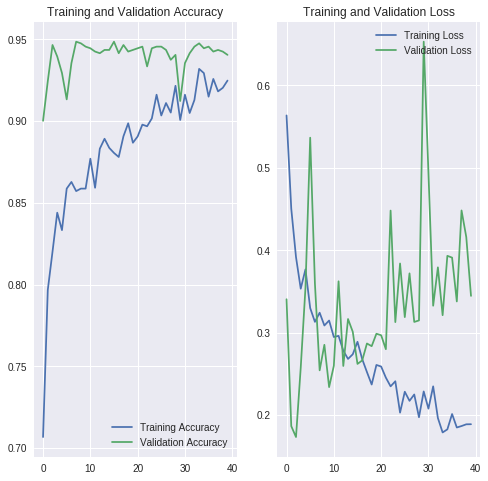

In [65]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Fine tuning
In our feature extraction experiment, we were only training a few layers on top of an Inception V3 base model. The weights of the pre-trained network were **not** updated during training. One way to increase performance even further is to "fine-tune" the weights of the top layers of the pre-trained model alongside the training of the top-level classifier. The training process will force the weights to be tuned from generic features maps to features associated specifically to our dataset.

Note: this should only be attempted after you have trained the top-level classifier with the pre-trained model set to non-trainable. If you add a randomly initialized classifier on top of a pre-trained model and attempt to train all layers jointly, the magnitude of the gradient updates will be too large (due to the random weights from the classifier) and your pre-trained model will just forget everything it has learned.

Additionally, the reasoning behind fine-tuning the top layers of the pre-trained model rather than all layers of the pre-trained model is the following: in a convnet, the higher up a layer is, the more specialized it is. The first few layers in a convnet learned very simple and generic features, which generalize to almost all types of images. But as you go higher up, the features are increasingly more specific to the dataset that the model was trained on. The goal of fine-tuning is to adapt these specialized features to work with the new dataset.

All we need to do is set the top layers of Inception V3 base model to be trainable, recompile the model (necessary for these changes to take effect), and resume training. 

### Freeze earlier layers of the model



In [66]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine tune from this layer onwards
fine_tune_at = 300

# Freeze all the layers lower than the fine_tune_at layer
for layer in model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  311


### Compile the model
Let's compile the model training it.

In [0]:
# We will use SGD with a very low learning rate as the optimizer
model.compile(loss='binary_crossentropy',
              optimizer = tf.keras.optimizers.RMSprop(lr=2e-5),
              metrics=['accuracy'])

### Train the model

In [68]:
history = model.fit_generator(train_generator, 
                              train_generator.n // batch_size, 
                              epochs=epochs, 
                              workers=4,
                              validation_data=validation_generator, 
                              validation_steps=validation_generator.n // batch_size)

Epoch 1/40
62/62 [==============================] - 20s 321ms/step - loss: 0.1594 - acc: 0.9330 - val_loss: 0.3630 - val_acc: 0.9456
Epoch 2/40
62/62 [==============================] - 11s 174ms/step - loss: 0.1679 - acc: 0.9370 - val_loss: 0.3509 - val_acc: 0.9405
Epoch 3/40
62/62 [==============================] - 11s 176ms/step - loss: 0.1553 - acc: 0.9355 - val_loss: 0.3585 - val_acc: 0.9446
Epoch 4/40
62/62 [==============================] - 11s 176ms/step - loss: 0.1644 - acc: 0.9365 - val_loss: 0.3392 - val_acc: 0.9446
Epoch 5/40
62/62 [==============================] - 11s 178ms/step - loss: 0.1604 - acc: 0.9320 - val_loss: 0.3457 - val_acc: 0.9405
Epoch 6/40
62/62 [==============================] - 11s 182ms/step - loss: 0.1654 - acc: 0.9365 - val_loss: 0.3693 - val_acc: 0.9456
Epoch 7/40
62/62 [==============================] - 11s 184ms/step - loss: 0.1529 - acc: 0.9390 - val_loss: 0.3477 - val_acc: 0.9395
Epoch 8/40
62/62 [==============================] - 11s 180ms/step - 

### Exam learning curves of fine tuning
Let's take a look at the learning curves of the training and validation accuracy / loss, when fine tuning the last few layers of the Inception_v3 base model, as well as the classifier on top of it. Note the validation loss much higher than the training loss which means there maybe some overfitting. 

**Note**: the training dataset is fairly small, and is similar to the original datasets that Inception_v3 was trained on, so fine-tuning may result in overfitting.


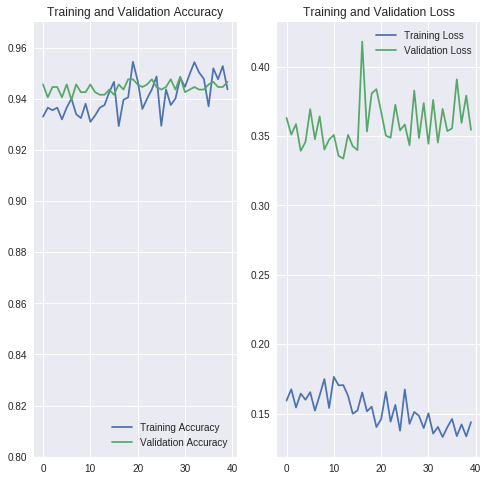

In [69]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.ylim((0.8, 0.97))
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Key takeaways
In summary here is what we covered in this tutorial on how to do transfer learning using a pre-trained model to improve accuracy:
* Using a pre-trained model for **feature extraction** - when working with a small dataset, it is common to leverage the features learned by a model trained on a larger dataset in the same domain. This is done by instantiating the pre-trained model and adding a fully connected classifier on top. The pre-trained model is "frozen" and only the weights of the classifier are updated during training.
In this case, the convolutional base extracts all the features associated with each image and we train a classifier that determines, given these set of features to which class it belongs.
* **Fine-tuning** a pre-trained model - to further improve performance, one might want to repurpose the top-level layers of the pre-trained models to the new dataset via fine-tuning.
In this case, we tune our weights such that we learn highly specified and high level features specific to our dataset. This only make sense when the training dataset is large and very similar to the orginial dataset that the pre-trained model was trained on.
